In [1]:
#基于超参数优化的Gradient Boosting 的销售预测

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/

In [7]:
#读取数据
raw_data = pd.read_table('products_sales.txt', delimiter=',')

In [8]:
# 数据审查和校验
# 数据概览
print ('{:*^60}'.format('Data overview:'))
print (raw_data.tail(2))  # 打印原始数据后2条
print ('{:*^60}'.format('Data dtypes:'))
print (raw_data.dtypes)  # 打印数据类型
print ('{:*^60}'.format('Data DESC:'))
print (raw_data.describe().round(1).T)  # 打印原始数据基本描述性信息

***********************Data overview:***********************
     limit_infor  campaign_type  campaign_level  product_level  \
729            0              6               0              1   
730            0              6               0              1   

     resource_amount  email_rate  price  discount_rate  hour_resouces  \
729                8         0.8  150.0           0.87            987   
730                9         0.8  149.0           0.84           1448   

     campaign_fee  orders  
729          2298    3285  
730          3392    4840  
************************Data dtypes:************************
limit_infor          int64
campaign_type        int64
campaign_level       int64
product_level        int64
resource_amount      int64
email_rate         float64
price              float64
discount_rate      float64
hour_resouces        int64
campaign_fee         int64
orders               int64
dtype: object
*************************Data DESC:*************************
   

In [9]:
# 查看值域分布
col_names = ['limit_infor', 'campaign_type', 'campaign_level', 'product_level']  # 定义要查看的列
for col_name in col_names:  # 循环读取每个列
    unque_value = np.sort(raw_data[col_name].unique())  # 获得列唯一值
    print ('{:*^50}'.format('{1} unique values:{0}').format(unque_value, col_name))  # 打印输出

**************limit_infor unique values:[ 0  1 10]***************
**************campaign_type unique values:[0 1 2 3 4 5 6]***************
**************campaign_level unique values:[0 1]***************
**************product_level unique values:[1 2 3]***************


In [10]:
# 缺失值审查
na_cols = raw_data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print ('{:*^60}'.format('NA Cols:'))
print (na_cols)  # 查看具有缺失值的列
na_lines = raw_data.isnull().any(axis=1)  # 查看每一行是否具有缺失值
print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有缺失值的行总记录数

**************************NA Cols:**************************
limit_infor        False
campaign_type      False
campaign_level     False
product_level      False
resource_amount    False
email_rate         False
price               True
discount_rate      False
hour_resouces      False
campaign_fee       False
orders             False
dtype: bool
Total number of NA lines is: 2


In [11]:
# 相关性分析
print ('{:*^60}'.format('Correlation Analyze:'))
short_name = ['li', 'ct', 'cl', 'pl', 'ra', 'er', 'price', 'dr', 'hr', 'cf', 'orders']
long_name = raw_data.columns
name_dict = dict(zip(long_name, short_name))
print (raw_data.corr().round(2).rename(index=name_dict, columns=name_dict))  # 输出所有输入特征变量以及预测变量的相关性矩阵
print (name_dict)

********************Correlation Analyze:********************
          li    ct    cl    pl    ra    er  price    dr    hr    cf  orders
li      1.00 -0.03 -0.08 -0.04  0.05  0.04  -0.02  0.00  0.01 -0.04   -0.02
ct     -0.03  1.00  0.04  0.03  0.01 -0.01  -0.05 -0.01  0.06  0.06    0.06
cl     -0.08  0.04  1.00  0.06  0.05  0.05   0.02  0.02 -0.52  0.26    0.05
pl     -0.04  0.03  0.06  1.00 -0.12 -0.12   0.59 -0.04 -0.25 -0.23   -0.30
ra      0.05  0.01  0.05 -0.12  1.00  0.98   0.13  0.15  0.54  0.46    0.62
er      0.04 -0.01  0.05 -0.12  0.98  1.00   0.14  0.18  0.54  0.47    0.63
price  -0.02 -0.05  0.02  0.59  0.13  0.14   1.00  0.25 -0.08 -0.11   -0.10
dr      0.00 -0.01  0.02 -0.04  0.15  0.18   0.25  1.00  0.17  0.19    0.23
hr      0.01  0.06 -0.52 -0.25  0.54  0.54  -0.08  0.17  1.00  0.32    0.66
cf     -0.04  0.06  0.26 -0.23  0.46  0.47  -0.11  0.19  0.32  1.00    0.76
orders -0.02  0.06  0.05 -0.30  0.62  0.63  -0.10  0.23  0.66  0.76    1.00
{'limit_infor': 'li', 'camp

In [13]:
# 数据预处理
# 异常值处理
sales_data = raw_data.fillna(raw_data['price'].mean())  # 缺失值替换为均值
# sales_data = raw_data.drop('email_rate',axis=1) # 丢弃缺失值
sales_data = sales_data[sales_data['limit_infor'].isin((0, 1))]  # 只保留促销值为0和1的记录
sales_data['campaign_fee'] = sales_data['campaign_fee'].replace(33380, sales_data['campaign_fee'].mean())  # 将异常极大值替换为均值
print ('{:*^60}'.format('transformed data:'))
print (sales_data.describe().round(2).T.rename(index=name_dict))  # 打印处理完成数据基本描述性信息

*********************transformed data:**********************
        count     mean      std     min      25%      50%      75%      max
li      730.0     0.03     0.17    0.00     0.00     0.00     0.00     1.00
ct      730.0     3.00     2.01    0.00     1.00     3.00     5.00     6.00
cl      730.0     0.68     0.47    0.00     0.00     1.00     1.00     1.00
pl      730.0     1.40     0.55    1.00     1.00     1.00     2.00     3.00
ra      730.0     4.95     1.84    1.00     3.00     5.00     7.00     9.00
er      730.0     0.47     0.16    0.08     0.34     0.48     0.61     0.84
price   730.0   162.82    14.26  100.00   152.00   163.00   173.00   197.00
dr      730.0     0.81     0.08    0.49     0.77     0.82     0.87     0.98
hr      730.0   848.51   687.03    2.00   315.25   717.00  1096.50  3410.00
cf      730.0  3655.61  1561.27   20.00  2495.00  3660.00  4783.25  6946.00
orders  730.0  4531.27  1933.85   22.00  3196.50  4566.00  6021.25  8714.00


In [14]:
#分割数据集X和y
X = sales_data.iloc[:, :-1]  # 分割X
y = sales_data.iloc[:, -1]  # 分割y

In [15]:
# 模型最优化参数训练及检验
model_gbr = GradientBoostingRegressor()  # 建立GradientBoostingRegressor回归对象
parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'alpha': [0.1, 0.3, 0.6, 0.9]}  # 定义要优化的参数信息
model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5)  # 建立交叉检验模型对象
model_gs.fit(X, y)  # 训练交叉检验模型
print ('Best score is:', model_gs.best_score_)  # 获得交叉检验模型得出的最优得分
print ('Best parameter is:', model_gs.best_params_)  # 获得交叉检验模型得出的最优参数

Best score is: 0.9315608531942923
Best parameter is: {'alpha': 0.9, 'loss': 'huber', 'min_samples_leaf': 3}


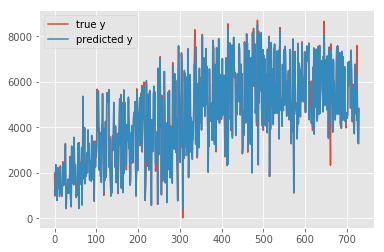

In [17]:
# 获取最佳训练模型
model_best = model_gs.best_estimator_  # 获得交叉检验模型得出的最优模型对象
model_best.fit(X, y)  # 训练最优模型
plt.style.use("ggplot")  # 应用ggplot自带样式库
plt.figure()  # 建立画布对象
plt.plot(np.arange(X.shape[0]), y, label='true y')  # 画出原始变量的曲线
plt.plot(np.arange(X.shape[0]), model_best.predict(X), label='predicted y')  # 画出预测变量曲线
plt.legend(loc=0)  # 设置图例位置
plt.show()  # 展示图像

In [18]:
# 新数据集预测
New_X = np.array([[1, 1, 0, 1, 15, 0.5, 177, 0.66, 101, 798]])  # 要预测的新数据记录
print ('{:*^60}'.format('Predicted orders:'))
print (model_best.predict(New_X).round(0))  # 打印输出预测值

*********************Predicted orders:**********************
[779.]
